### Import libraries

In [239]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# geolocation data extraction
from geopy.geocoders import Nominatim 

# handling  requests and working with json files
import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# similarity measures between vectors
from scipy.spatial import distance

# clusterization
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


## 1. Comparison of clients reviews profiles

### 1.1 Data

Data about guest reviews of Chicago hotels was taken from www.bookings.com website

#### Review data about Chicago hotels

In [213]:
df = pd.read_excel('Marriott Chicago reviews.xlsx')
df.head()

,Name,Staff,Facilities,Cleanliness,Comfort,Value for money,Location
0,Chicago Marriott Southwest at Burr Ridge,8.4,8.6,8.7,9.0,8.1,8.6
1,Chicago Marriott at Medical District/UIC,9.1,8.8,9.3,9.3,8.0,8.9
2,JW Marriott Chicago,8.7,8.5,8.7,8.7,7.7,8.9
3,Chicago Marriott Downtown Magnificent Mile,8.8,8.6,8.9,8.9,8.0,9.4
4,Marriott Marquis Chicago,8.9,9.1,9.3,9.3,8.0,8.9


#### Review data about New York hotel

In [214]:
# data on New York Marriot Downtown 
ny_review_profile = np.array([8.4, 8.6, 8.9, 8.9, 7.9, 9.0])


### 1.2 Similarity comparison of of review profiles


#### Evaluate similarity of review profiles of Chicago and New York hotels

In [219]:
rev_dist=[]
X = np.array(ny_neighb_profile)
for i in range(df.shape[0]):
    Y=np.array(df[['Staff','Facilities','Cleanliness','Comfort','Value for money','Location']].iloc[i])
    rev_dist.append(distance.minkowski(X, Y, 2))
df['Rev_dist']=rev_dist
df['Rev_rank']=df['Rev_dist'].rank()
df.to_excel(r'C:\Users\Mindaugas\Desktop\capstone project\Chicago review profiles.xlsx') # save to file
df.head()

,Name,Staff,Facilities,Cleanliness,Comfort,Value for money,Location,Rev_dist,Rev_rank
0,Chicago Marriott Southwest at Burr Ridge,8.4,8.6,8.7,9.0,8.1,8.6,20.587258,4.0
1,Chicago Marriott at Medical District/UIC,9.1,8.8,9.3,9.3,8.0,8.9,21.415210,7.0
2,JW Marriott Chicago,8.7,8.5,8.7,8.7,7.7,8.9,20.511733,3.0
3,Chicago Marriott Downtown Magnificent Mile,8.8,8.6,8.9,8.9,8.0,9.4,21.088366,6.0
4,Marriott Marquis Chicago,8.9,9.1,9.3,9.3,8.0,8.9,21.455051,8.0


#### Most similar hotels according to reviews profile

In [221]:
df[['Rev_rank','Name','Rev_dist']].sort_values(by='Rev_dist',ascending=True)[0:3]

,Rev_rank,Name,Rev_dist
6,1.0,Marriott Chicago O’Hare,19.578948
5,2.0,Chicago Marriott Midway,20.276518
2,3.0,JW Marriott Chicago,20.511733


## 2. Comparison of neighbourhood profiles

In [5]:
# foursquare API credentials for geolocation
CLIENT_ID = 'KP0R3JODDTYWNTWRFQVP5HJF4M4RW4LYIMK1M2BRACLI2FHX' # your Foursquare ID
CLIENT_SECRET = 'MQMXU505US2M1NM0UQMNLGZBWIOD3CVN0R5IPVO430IMVQLH' # your Foursquare Secret
VERSION = '20180604'


### 2.1 Neighbourhood profile of New York Marriott Downtown

#### Get geolocation data of hotel in New York

In [33]:
# Get geolocation data of hotel in New York
address='New York Marriott Downtown, NY'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.709426750000006 -74.01434310493437


#### Send request to get data on the locations around the hotel

In [34]:
LIMIT = 100  #  number of venues returned by Foursquare API
radius = 500 #  radius around the hotel

# call address to foursquare API
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [35]:
results = requests.get(url).json()

#### Extract categories of the venues around the hotel

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
venues = results['response']['groups'][0]['items']
ny_venues = json_normalize(venues) 

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
ny_venues =ny_venues.loc[:, filtered_columns]

# filter the category for each row
ny_venues['venue.categories'] = ny_venues.apply(get_category_type, axis=1)
# clean columns
ny_venues.columns = [col.split(".")[-1] for col in ny_venues.columns]

ny_venues.to_excel(r'C:\Users\Mindaugas\Desktop\capstone project\NY hotel venues.xlsx') # save to file

#### Show and count all unique categories of the venues around the hotel

In [39]:
print(str(len(ny_venues['categories'].unique())) + " distinct categories found")
ny_venues['categories'].unique()

63 distinct categories found


array(['Park', 'Memorial Site', 'Gourmet Shop', 'Coffee Shop',
       'Jewelry Store', 'Museum', 'Pet Store', 'Lingerie Store',
       'Food Truck', 'Pub', 'Steakhouse', 'Wine Shop', 'Garden',
       'Auditorium', 'Dog Run', 'Gym / Fitness Center', 'Trail',
       'Grocery Store', 'Ice Cream Shop', 'Gym', 'Tree', 'Hotel', 'Plaza',
       'Gift Shop', 'Mexican Restaurant', 'Salad Place', 'Playground',
       'Cooking School', 'Food Court', 'American Restaurant',
       'Electronics Store', 'Shopping Mall', 'Pizza Place',
       'Performing Arts Venue', 'Scenic Lookout', 'Building',
       'French Restaurant', 'BBQ Joint', 'Monument / Landmark',
       'Smoke Shop', 'Bar', 'Italian Restaurant', 'Café',
       "Doctor's Office", 'Rental Car Location', 'Bistro', 'Beer Garden',
       'Historic Site', 'Clothing Store', "Women's Store", 'Cupcake Shop',
       'New American Restaurant', 'Deli / Bodega', 'Japanese Restaurant',
       'Burger Joint', 'Burrito Place', 'Boat or Ferry', 'Event Spa

In [14]:
ny_venues.head()

,name,categories,lat,lng
0,Liberty Park,Park,40.710384,-74.013868
1,9/11 Memorial South Pool,Memorial Site,40.711039,-74.013082
2,Eataly Downtown,Gourmet Shop,40.710075,-74.011976
3,National September 11 Memorial & Museum (Natio...,Memorial Site,40.711349,-74.013197
4,Blue Bottle Coffee,Coffee Shop,40.710589,-74.012371


#### Form the profile of the neighbourhood

Count the number of tourist attracions and sites for seeing

In [24]:
sites_list = ['Park','Site','Museum','Auditorium','Garden','Trail','Plaza','Playground','Venue','Lookout','Building',
             'Monument','Landmark']
sites_count=0
for word in sites_list:
    for i in range(ny_venues.shape[0]): 
        if word in ny_venues['categories'].iloc[i]:
           sites_count += 1 
print(sites_count)

28


Count the number of food and drink establishments (other than the restaurants) around the hotel

In [25]:
foods_list = ['Pub','Bar','Café','Food','Place','Joint','Bistro']
foods_count=0
for word in foods_list:
    for i in range(ny_venues.shape[0]): 
        if word in ny_venues['categories'].iloc[i]:
            foods_count += 1 
print(foods_count)

21


Count the number of shops/stores around the hotel

In [26]:
shops_list = ['Store','Shop','Mall','Deli','Bodega']
shops_count=0
for word in shops_list:
    for i in range(ny_venues.shape[0]): 
        if word in ny_venues['categories'].iloc[i]:
            shops_count += 1 
print(shops_count)

29


Count number of restaurants (other than steakhouses) around the hotel

In [27]:
rests_count = 0
for i in range(ny_venues.shape[0]):
    if 'Restaurant' in ny_venues['categories'].iloc[i]:
        rests_count += 1
print(rests_count)   

7


Count number of stakehouses around the hotel

In [28]:
steak_count = 0
for i in range(ny_venues.shape[0]):
    if 'Steakhouse' in ny_venues['categories'].iloc[i]:
        steak_count += 1
        print(ny_venues.iloc[i])
print(steak_count)   

name          Morton's The Steakhouse
categories                 Steakhouse
lat                           40.7097
lng                           -74.014
Name: 11, dtype: object
1


Count number of other venues around the hotel

In [29]:
others_count = ny_venues.shape[0]-sites_count-rests_count-foods_count-steak_count-shops_count
print(others_count)

14


#### Form neighbourhood profile of New York Marriott Downtown

In [30]:
ny_neighb_profile = np.array([sites_count, shops_count, foods_count, rests_count, steak_count, others_count])/ny_venues.shape[0]
print(str(ny_neighb_profile))                       

[0.28 0.29 0.21 0.07 0.01 0.14]


### 2.2 Neighbourhood profiles of Chicago hotels

### 2.2.1  Data extraction

#### Get geolocation data of Chicago hotels

In [41]:
Latitude=[]; Longitude=[]
for i in  range(df.shape[0]):
    geolocator = Nominatim(user_agent="foursquare_agent")
    address = df['Name'].iloc[i]
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
    
df['Latitude']=pd.Series(Latitude)
df['Longitude']=pd.Series(Longitude)


In [177]:
df[['Name','Latitude','Longitude']].head()  

,Name,Latitude,Longitude
0,Chicago Marriott Southwest at Burr Ridge,41.756057,-87.909524
1,Chicago Marriott at Medical District/UIC,41.873734,-87.666157
2,JW Marriott Chicago,41.879074,-87.633011
3,Chicago Marriott Downtown Magnificent Mile,41.892122,-87.624854
4,Marriott Marquis Chicago,41.853899,-87.620267


#### Extract data about the venues around Chicago hotels and form neihgbourhood profiles

In [130]:
sites_list = ['Park','Site','Museum','Auditorium','Garden','Trail','Plaza','Playground','Venue','Lookout','Building',
             'Monument','Landmark']
foods_list = ['Pub','Bar','Café','Food','Place','Joint','Bistro']
shops_list = ['Store','Shop','Mall','Deli','Bodega']


chi_neighb_profiles=[]
radius=500
LIMIT=100

for i in range(df.shape[0]):
    # ------------------------coordinates of the hotel----------------------------------
    lat = df['Latitude'].iloc[i] 
    lng = df['Longitude'].iloc[i]
    
    #--------------------- create the API request URL-----------------------------------
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    
    #----------------- extract categories of venues around the hotel-------------------------------
    venue = results['response']['groups'][0]['items']
    chicago_venue = json_normalize(venue) 
    categories=chicago_venue.apply(get_category_type, axis=1)
    filtered_columns = ['venue.name', 'venue.categories']
    chicago_venue =chicago_venue.loc[:, filtered_columns]
    chicago_venue['venue.categories'] = chicago_venue.apply(get_category_type, axis=1)
    chicago_venue.columns = [col.split(".")[-1] for col in chicago_venue.columns]

    #-------------- count categories and form neighbourhood profile of the Chicago venue----------------------
    # sites
    sites_count=0
    for word in sites_list:
        for i in range(chicago_venue.shape[0]): 
            if word in chicago_venue['categories'].iloc[i]:
               sites_count += 1             
    # food 
    foods_count=0
    for word in foods_list:
        for i in range(chicago_venue.shape[0]): 
            if word in chicago_venue['categories'].iloc[i]:
                foods_count += 1 
    # restaurants
    rests_count = 0
    for i in range(chicago_venue.shape[0]):
        if 'Restaurant' in chicago_venue['categories'].iloc[i]:
            rests_count += 1
    # shops
    shops_count=0
    for word in shops_list:
        for i in range(chicago_venue.shape[0]): 
            if word in chicago_venue['categories'].iloc[i]:
                shops_count += 1             
    # steakhouses
    steak_count = 0
    for i in range(chicago_venue.shape[0]):
        if 'Steakhouse' in chicago_venue['categories'].iloc[i]:
            steak_count += 1       
    others_count = chicago_venue.shape[0]-sites_count-rests_count-foods_count-steak_count-shops_count

    #-------------- form and store neighbourhoods profile
    neighb_profile = np.array([sites_count, shops_count, foods_count, rests_count, steak_count, others_count])/chicago_venue.shape[0]
    chi_neighb_profiles.append(neighb_profile)
    

#### Store extracted data in a new dataframe and save to file

In [149]:
chi_neighb = pd.DataFrame( chi_neighb_profiles, columns = ['Sites','Shops','Foods','Restaurants','Steakhouses','Other'])
chi_neighb['Name']=df['Name']; 
chi_neighb['Latitude']=df['Latitude']; chi_neighb['Longitude']=df['Longitude']
chi_neighb[['Name','Sites','Shops','Foods','Restaurants','Steakhouses','Other','Latitude','Longitude']].head()


,Name,Sites,Shops,Foods,Restaurants,Steakhouses,Other,Latitude,Longitude
0,Chicago Marriott Southwest at Burr Ridge,0.062500,0.562500,0.000000,0.187500,0.00,0.187500,41.756057,-87.909524
1,Chicago Marriott at Medical District/UIC,0.000000,0.214286,0.285714,0.214286,0.00,0.285714,41.873734,-87.666157
2,JW Marriott Chicago,0.059524,0.261905,0.297619,0.250000,0.00,0.130952,41.879074,-87.633011
3,Chicago Marriott Downtown Magnificent Mile,0.030000,0.270000,0.160000,0.300000,0.05,0.190000,41.892122,-87.624854
4,Marriott Marquis Chicago,0.134615,0.076923,0.230769,0.211538,0.00,0.346154,41.853899,-87.620267


### 2.2.2  Similarity comparison of neighbourhood profiles

#### Evaluate similarity of neighbourhood profiles of Chicago and New York hotels

In [223]:
neighb_dist=[]
X = np.array(ny_neighb_profile)
for i in range(chi_neighb.shape[0]):
    Y=np.array(chi_neighb[['Sites','Shops','Foods','Restaurants','Steakhouses','Other']].iloc[i])
    neighb_dist.append(distance.minkowski(X, Y, 2))
chi_neighb['Neighb_dist']=neighb_dist
chi_neighb['Neighb_rank']=chi_neighb['Neighb_dist'].rank()
chi_neighb.to_excel(r'C:\Users\Mindaugas\Desktop\capstone project\Chicago neighbourhood profiles.xlsx') # save to file


#### Most similar hotels according to neighbourhood profile

In [226]:
chi_neighb[['Neighb_rank','Name','Neighb_dist']].sort_values(by='Neighb_dist',ascending=True)[0:9]

,Neighb_rank,Name,Neighb_dist
7,1.0,Chicago Marriott Suites O’Hare,0.211276
2,2.0,JW Marriott Chicago,0.299430
3,3.0,Chicago Marriott Downtown Magnificent Mile,0.349857
4,4.5,Marriott Marquis Chicago,0.360003
8,4.5,Chicago Marriott Oak Brook,0.360003
1,6.0,Chicago Marriott at Medical District/UIC,0.363341
6,7.0,Marriott Chicago O’Hare,0.403980
0,8.0,Chicago Marriott Southwest at Burr Ridge,0.426409
5,9.0,Chicago Marriott Midway,0.431476


## 3. Joint comparison

### 3.1 Evaluate joint ranks of similarity

We define a joint similarity index, which is the sum of similarity ranks based on both reviews and neighbourhood profiles. The lower the sum of ranks indicates the higher similarity between hotels.  

#### Estimate joint similarity index

In [227]:
rank_sum=df['Rev_rank']+chi_neighb['Neighb_rank']
df['Joint rank']=rank_sum

#### Most similar hotels according to both reviews and neighbourhood profile

In [228]:
df[['Name','Joint rank']].sort_values(by='Joint rank',ascending=True)[0:3]

,Name,Joint rank
2,JW Marriott Chicago,5.0
6,Marriott Chicago O’Hare,8.0
3,Chicago Marriott Downtown Magnificent Mile,9.0


Thus, JW Marriott Chicago seems to show highest similarity to New York Marriott Downtown based on joint rank sum index.

### 3.2 Clusterization of hotels based on similarity of reviews and neighbourhood profiles

#### Extract and visualize data

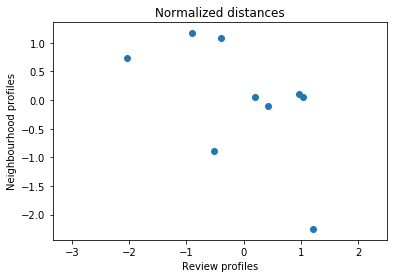

In [277]:
X=np.zeros([df.shape[0],2])
X[:,0]=np.array(df['Rev_dist'])
X[:,1]=np.array(chi_neighb['Neighb_dist'])
X = StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1])
plt.title('Normalized distances')
plt.xlabel('Review profiles')
plt.ylabel('Neighbourhood profiles')
plt.axis('equal')
plt.show()

#### Cluster data using k-nearest neighbours algorithm


In [278]:
k = 3 # number of clusters
knn = KMeans(n_clusters=k, random_state=9).fit(X)
knn.labels_

array([1, 0, 0, 0, 0, 1, 1, 2, 0])

#### Cluster labels of the hotels


In [279]:
df['Cluster']=knn.labels_
df[['Name','Cluster']]

,Name,Cluster
0,Chicago Marriott Southwest at Burr Ridge,1
1,Chicago Marriott at Medical District/UIC,0
2,JW Marriott Chicago,0
3,Chicago Marriott Downtown Magnificent Mile,0
4,Marriott Marquis Chicago,0
5,Chicago Marriott Midway,1
6,Marriott Chicago O’Hare,1
7,Chicago Marriott Suites O’Hare,2
8,Chicago Marriott Oak Brook,0


#### Visualize clusters 

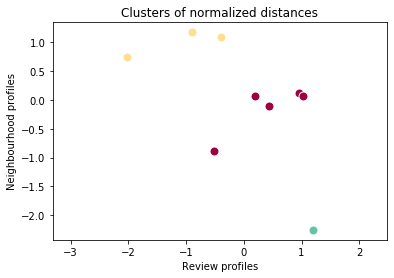

In [280]:
fig = plt.figure(figsize=(6, 4))
colors = plt.cm.Spectral(np.linspace(0, 0.8, len(set(knn.labels_))))
ax = fig.add_subplot(1, 1, 1)


for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):
    my_members = (knn.labels_ == k)
    cluster_center = knn.cluster_centers_[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='o',markersize=9)

plt.title('Clusters of normalized distances')
plt.xlabel('Review profiles')
plt.ylabel('Neighbourhood profiles')
plt.axis('equal')
plt.show()